# **Creating RNN model using Keras IMDB dataset**

**Loading the dataset and applying padding**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, roc_curve, auc

import kerastuner as kt
from kerastuner.tuners import RandomSearch

import warnings
warnings.filterwarnings("ignore")

C:\Users\Buse\AppData\Local\Temp\ipykernel_27720\1951142177.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
# 0 -> negative comment, 1 -> positive comment
(x_train, y_train),(x_test, y_test) = imdb.load_data(num_words= 10000) # Most common used 10000 words.

# Data Preprocessing : Padding method is used to make comments the same length.
maxlen = 100
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

**Creating and compiling the RNN Model**

In [3]:
# hp : hyperparameter
def build_model(hp) : 
    model = Sequential() # base model
    
    # Embedding layer :  Turns words into vectors.
    model.add(Embedding(input_dim=10000,
                        output_dim = hp.Int("embedding_output" , min_value=32, max_value = 256, step =32),
                        input_length = maxlen))
    # SimpleRNN 
    model.add(SimpleRNN(units= hp.Int("rnn_units", min_value=32, max_value =256, step=32)))
    # Dropout Layer : Prevents overfitting
    model.add(Dropout(rate= hp.Float("dropout_rate",min_value = 0.25, max_value = 1, step=0.25))) # 0.25, 0.50, 0.75, 1
    # Output Layer : 1 cell and sigmoid func.
    model.add(Dense(1,activation="sigmoid")) # Sigmoid activation func is used for binary classification. The output of sigmoid is between 0-1.
    
    model.compile(optimizer = hp.Choice("optimizer", ["adam", "rmsprop"]), # adam or rmsprop can be used.
                  loss = "binary_crossentropy", # the loss function is used for binary classification
                  metrics = ["accuracy", "AUC"]
                  )
    return model

**Hyperparameter Search and Training the Model**

In [ ]:
tuner = RandomSearch(
    build_model, # model function to be optimized
    objective= "val_loss", # It looks at validation loss, lowest is best.
    max_trials=5, # trying 5 different models
    executions_per_trial = 1,
    directory = "rnn_tuner_directory",
    project_name = "imdb_rnn" # project name
)

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Training 
tuner.search(x_train, y_train,
            epochs = 10,
            validation_split = 0.2,
            callbacks = [early_stopping])

Trial 5 Complete [00h 00m 56s]
val_loss: 0.42533618211746216

Best val_loss So Far: 0.42533618211746216
Total elapsed time: 00h 06m 28s


**Evaluating the best Model**

In [5]:
best_model = tuner.get_best_models(num_models=1)[0] 

# Testing by using the best model
loss, accuracy, auc_score = best_model.evaluate(x_test,y_test)
print(f"Test Loss : {loss:.3f}\nTest Accuracy : {accuracy:.3f}\nTest AUC : {auc_score:.3f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.8849 - accuracy: 0.8081 - loss: 0.4278
Test Loss : 0.426
Test Accuracy : 0.809
Test AUC : 0.886


In [ ]:
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32") #  If estimated values ​​are greater than 0.5, they are rounded to 1. So it is considered positive.

print(classification_report(y_test, y_pred))


782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
              precision    recall  f1-score   support

           0       0.80      0.83      0.81     12500
           1       0.82      0.79      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



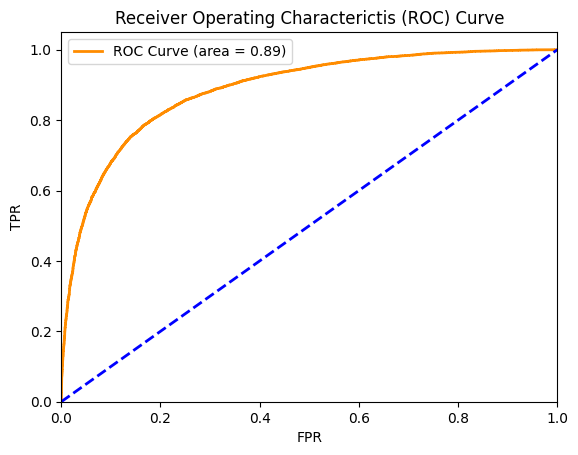

In [ ]:
# Calculating ROC Curve
fpr, tpr,_ = roc_curve(y_test, y_pred_prob) #  False Positive Rate and True Positive Rate
roc_auc = auc(fpr,tpr) # The area under the Roc curve is calculated. The closer to 1 the better.

# Visualizing the Roc Curve
plt.figure()
plt.plot(fpr, tpr, color= "darkorange", lw=2, label = "ROC Curve (area = %0.2f)" % roc_auc)
plt.plot([0,1], [0,1], color = "blue" , lw=2, linestyle="--") 
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Receiver Operating Characterictis (ROC) Curve")
plt.legend()
plt.show()